In [33]:
# Main reference for model
# https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook#Error-Metrics-On-Test-Set

# How XGBoost handles missing values
# https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4

# Why this model doesn't include feature normalisation
# https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalize-data-for-xgboost

# Stock values are stated in terms of the closing price and the adjusted closing price. 
# The closing price is the raw price, which is just the cash value of the last transacted price before the market closes.
# The adjusted closing price factors in anything that might affect the stock price after the market closes
# https://www.investopedia.com/terms/a/adjusted_closing_price.asp

In [34]:
import xgboost as xgb
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Loading

In [35]:
df = pd.read_csv("data.csv", parse_dates=["Date"])
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Ticker,Daily Return %
0,2017-01-03,46.750000,45.740002,45.930000,46.490002,1739600.0,44.718174,A,NaN
1,2017-01-04,47.380001,46.820000,46.930000,47.099998,1821300.0,45.304916,A,0.013121
2,2017-01-05,47.070000,46.360001,47.049999,46.540001,1503700.0,44.766273,A,-0.011889
3,2017-01-06,48.070000,46.560001,46.630001,47.990002,2883400.0,46.161007,A,0.031156
4,2017-01-09,48.560001,47.910000,48.009998,48.139999,2575300.0,46.305286,A,0.003126


# Feature Engineering

In [36]:
# Map tickers to a numeric representation (Used at the end to verify predictions)
tickers_avail = df["Ticker"].unique()
tickers_df = pd.DataFrame({
    "Ticker": tickers_avail,
    "Ticker Number": list(range(len(tickers_avail)))
})

In [37]:
# The model will not accept datetime, hence create a feature for each date part
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

In [38]:
# Represent tickers as numbers to avoid text values
df["Ticker_Cat"] = pd.Categorical(df["Ticker"])
df["Ticker_Num"] = df["Ticker_Cat"].cat.codes

In [39]:
df.drop(["Ticker", "Ticker_Cat", "Close"], inplace=True, axis=1)

In [40]:
df.head()

,Date,High,Low,Open,Volume,Adj Close,Daily Return %,Year,Month,Day,Ticker_Num
0,2017-01-03,46.750000,45.740002,45.930000,1739600.0,44.718174,NaN,2017,1,3,0
1,2017-01-04,47.380001,46.820000,46.930000,1821300.0,45.304916,0.013121,2017,1,4,0
2,2017-01-05,47.070000,46.360001,47.049999,1503700.0,44.766273,-0.011889,2017,1,5,0
3,2017-01-06,48.070000,46.560001,46.630001,2883400.0,46.161007,0.031156,2017,1,6,0
4,2017-01-09,48.560001,47.910000,48.009998,2575300.0,46.305286,0.003126,2017,1,9,0


## Train-Eval split

In [41]:
train_split = 0.9
# Set the date at which to split train and eval data
# Of the unique dates available, pick the split between train and eval dates
dates_avail = df["Date"].unique()
split_date_index = int(dates_avail.shape[0] * train_split)
split_date = dates_avail[split_date_index]
# Train data is on or before the split date
train_df = df.query("Date <= @split_date")
# And eval data is after
eval_df = df.query("Date > @split_date")

features = ["Year", "Month", "Day", "High", "Low", "Open", "Volume", "Ticker_Num", "Daily Return %"]
label = ["Adj Close"]
x_train = train_df[features]
y_train = train_df[label]
x_eval = eval_df[features]
y_eval = eval_df[label]

## Build model

Good set of parameters
* n_estimators: 1000
* max_depth: 5
* min_child_weight: 2
* learning_rate: 0.3
* early_stopping_rounds: 20

In [42]:
model = xgb.XGBRegressor(
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 2,
    learning_rate = 0.3
)

In [43]:
model.fit(
    x_train,
    y_train,
    eval_set = [(x_train, y_train), (x_eval, y_eval)],
    early_stopping_rounds = 20,
    verbose = False
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

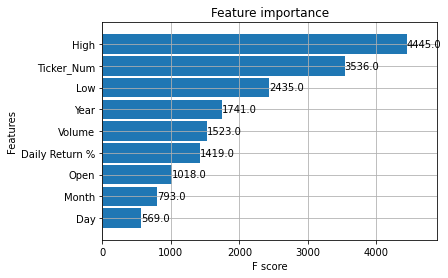

In [44]:
# Check feature importance
xgb.plot_importance(model, height=0.9)

## Evaluate model

In [45]:
# Create a final dataframe to verify the predictions
df_pred = x_eval.copy()
# Recreate a column for the complete date
date_columns = ["Year", "Month", "Day"]
df_pred["Date"] = pd.to_datetime(df_pred[date_columns])
df_pred.drop(date_columns, inplace=True, axis=1)

In [46]:
# Predict data for the eval dataset and save the predicted Adj Close as a new column
df_pred["Adj Close_Pred"] = model.predict(x_eval)

In [47]:
# Add the true Adj Close into the dataset
# Indexes were not reset, so we can join on the index (the indexes are reset during the merge though)
df_pred = df_pred.merge(
    y_eval, 
    how = "inner", 
    left_index = True, 
    right_index = True
)
# As well as the ticker names
df_pred = df_pred.merge(
    tickers_df, 
    how = "inner",
    left_on = "Ticker_Num",
    right_on = "Ticker Number"
)
df_pred.drop(["Ticker_Num", "Ticker Number"], inplace=True, axis=1)

In [48]:
mse = mean_squared_error(
    y_true = df_pred["Adj Close"],
    y_pred = df_pred["Adj Close_Pred"]
)
mae = mean_absolute_error(
    y_true = df_pred["Adj Close"],
    y_pred = df_pred["Adj Close_Pred"]
)
# Mean Absolute Percentage Error is the percentage of how off the predicted values are
mape = (
    np.abs(df_pred["Adj Close"] - df_pred["Adj Close_Pred"]) / df_pred["Adj Close"]
).mean() * 100

print(f"Mean Squared Error is {round(mse, 2)}")
print(f"Mean Absolute Error is {round(mae, 2)}")
print(f"Mean Absolute Percentage Error is {round(mape, 2)}%")

Mean Squared Error is 14.19
Mean Absolute Error is 1.56
Mean Absolute Percentage Error is 1.13%


In [49]:
df_pred["Squared Error"] = (df_pred["Adj Close"] - df_pred["Adj Close_Pred"]) ** 2
df_pred["Absolute Error"] = df_pred["Squared Error"].apply(np.abs)
df_pred["Absolute Percentage Error"] = (
    np.abs(df_pred["Adj Close"] - df_pred["Adj Close_Pred"]) / df_pred["Adj Close"]
) * 100

In [50]:
# Prepare data for visualisation
ticker = "AMD"
df_pred_viz = df_pred.query("Ticker == @ticker")

df_pred_viz = df_pred_viz.melt(
    id_vars = ["Date", "Ticker"],
    value_vars = ["Adj Close_Pred", "Adj Close"],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = "Date", 
    y = "Value", 
    color = "Value Type", 
    title = f"Adj Close: True vs. Predicted for {ticker}"
)
fig.show()

In [57]:
# Prepare data for visualisation
ticker = "NLOK"
df_pred_viz = df_pred.query("Ticker == @ticker")

df_pred_viz = df_pred_viz.melt(
    id_vars = ["Date", "Ticker"],
    value_vars = ["Adj Close_Pred", "Adj Close"],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = "Date", 
    y = "Value", 
    color = "Value Type", 
    title = f"Adj Close: True vs. Predicted for {ticker}"
)
fig.show()

In [52]:
# Prepare data for visualisation
tickers = ["AMD", "INTC"]
df_pred_viz = df_pred.query("Ticker in @tickers")
df_pred_viz = df_pred_viz.melt(
    id_vars = ["Date", "Ticker"],
    value_vars = ["Adj Close_Pred", "Adj Close"],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = "Date", 
    y = "Value", 
    color = "Value Type", 
    facet_row = "Ticker",
    title = f"Adj Close: True vs. Predicted for {tickers}"
)
fig.show()

In [53]:
# Prepare data for visualisation
tickers = ["GOOG", "AMZN", "GOOGL"]
df_pred_viz = df_pred.query("Ticker in @tickers")
df_pred_viz = df_pred_viz.melt(
    id_vars = ["Date", "Ticker"],
    value_vars = ["Adj Close_Pred", "Adj Close"],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = "Date", 
    y = "Value", 
    color = "Value Type", 
    facet_row = "Ticker",
    title = f"Adj Close: True vs. Predicted for {tickers}"
)
fig.show()

In [54]:
# df_pred_viz = df_pred.query("Ticker != "NVR"")
df_pred_viz = df_pred\
    .groupby(["Ticker"])\
    .mean()[["Squared Error", "Absolute Error", "Absolute Percentage Error"]]\
    .reset_index()\
    .sort_values(by = "Absolute Percentage Error", ascending = False)
df_pred_viz

fig = px.bar(
    df_pred_viz.head(n=10), 
    x = "Ticker", 
    y = "Absolute Percentage Error", 
    title = "Mean Absolute Percentage Error by Ticker (Top 10)"
)
fig.show()

In [59]:
df_pred_viz = df_pred.copy()
# This gets the first of the month for each date
df_pred_viz["Year Month"] = df_pred_viz["Date"].to_numpy().astype("datetime64[M]")

df_pred_viz = df_pred_viz\
    .groupby(["Year Month"])\
    .mean()[["Squared Error", "Absolute Error", "Absolute Percentage Error"]]\
    .reset_index()

fig = px.line(
    df_pred_viz, 
    x = "Year Month", 
    y = "Absolute Percentage Error", 
    title = "Mean Absolute Percentage Error by Month Year",
)
fig.update(layout_yaxis_range = [0, 1.5] )
fig.show()

# Output model

In [56]:
model.save_model("sp500_xgboost.json")